In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.model_selection
import albumentations as A
import cv2
import itertools
import os
import time
import csv
import math

import open3d as o3d
import trimesh

from pathlib import Path
from tqdm.notebook import tqdm

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset

from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler
from random import randint

torch.manual_seed(2020)

In [2]:
def fragment_df(path):
    rows = []
    for file in os.listdir(str(path)):
        if file[0] == 'f':
            file_name = file.split('.')[0]
            idx = int(file_name[8:])
            row = {'seq_no':idx}
            row['path'] = path
            rows.append(row)
    df = pd.DataFrame(rows)
    return df

In [3]:
train_path = Path('/home/mruddy/mydata/AMAAZE/processed_data/SheaLevallois')
val_path = Path('/home/mruddy/mydata/AMAAZE/processed_data/Bohunician')

df_train = fragment_df(train_path)
df_val = fragment_df(val_path)

In [4]:
data_path = Path('/home/mruddy/mydata/AMAAZE/processed_data/SheaLevallois')

rows = []
for file in os.listdir(str(data_path)):
    if file[0] == 'f':
        file_name = file.split('.')[0]
        idx = int(file_name[8:])
        row = {'seq_no':idx}
        row['path'] = data_path
        rows.append(row)
df = pd.DataFrame(rows)
len(df)

24

## Look at data

In [5]:
idx = 2
row = df_train.iloc[idx]
path = row['path']
no = row['seq_no']
print(no)
fragment = np.load(str(path/f'fragment{no}.npy'))
core = np.load(str(path/f'core{no}.npy'))

6


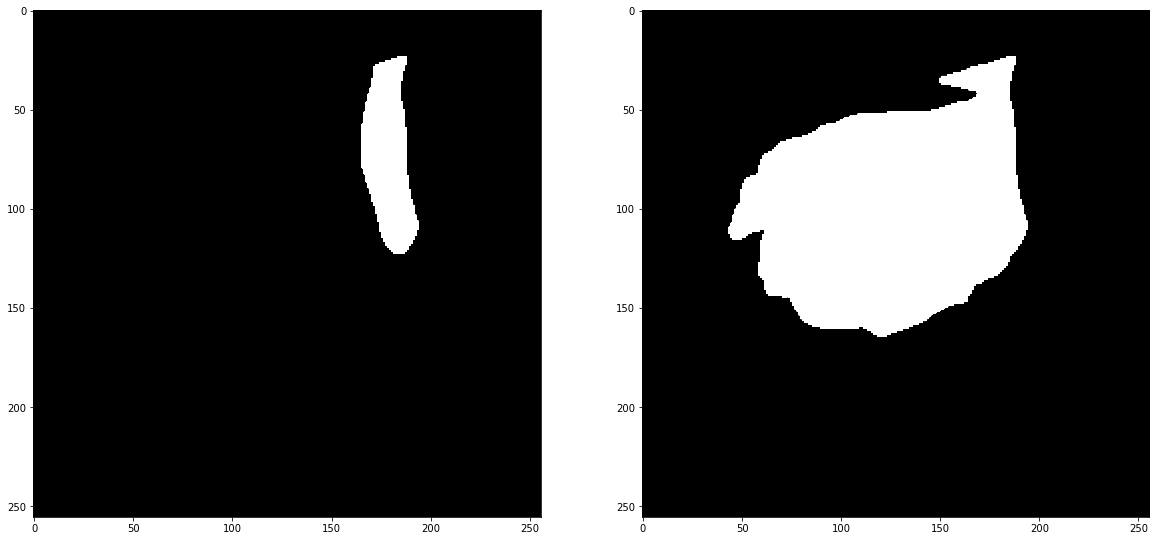

In [6]:
slc = 155
frag_slice = fragment[slc]
core_slice = core[slc]

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(frag_slice, vmin=0, vmax=1, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(core_slice, vmin=0, vmax=1, cmap='gray')

## Dataloaders

In [7]:
class LithicsDataset(Dataset):
    def __init__(self, df, augment=False):
        self.df = df
        self.augment = augment
        
        if self.augment == True:
            self.sp_transform = A.Compose([A.RandomCrop(width=224, height=224),
                                           A.HorizontalFlip(p=.5),
                                           A.VerticalFlip(p=.5),
                                           A.Rotate(limit = 10, 
                                                 border_mode = cv2.BORDER_CONSTANT, 
                                                 value = 0.0, p = .5),
                                          ])            
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        row = self.df.iloc[idx]
        path = row['path']
        no = row['seq_no']
        mask = np.load(str(path/f'fragment{no}.npy')) / 255
        img = np.load(str(path/f'core{no}.npy')) / 255
        
        # random integer 0 to 2, that determines axis of augmentation
        axis = randint(0,2)
        
        # center cut along axis of rotation
        if axis == 0:
            img = np.float32(np.transpose(img,[1,2,0]))
            mask = np.float32(np.transpose(mask,[1,2,0]))
        if axis == 1:
            img = np.float32(np.transpose(img,[0,2,1]))
            mask = np.float32(np.transpose(mask,[0,2,1]))
        if axis == 2:
            img = np.float32(img)
            mask = np.float32(mask)
        
        # apply augmentation
        if self.augment == True:
            # center cut along axis of rotation
            img = img[:,:,16:240]
            mask = mask[:,:,16:240]
            
            transformed = self.sp_transform(image=img, mask=mask) 
            img = transformed['image']
            mask = transformed['mask']
        
            
        # transform into an appropriately ordered tensor
        img = np.float32(img[np.newaxis,:,:,:])
        img = torch.tensor(img)
        mask = np.float32(mask[np.newaxis,:,:,:])
        mask = torch.tensor(mask)
        
        return img, mask

In [8]:
ds_train = LithicsDataset(df_train, augment=True)
ds_val = LithicsDataset(df_val)


N_train = len(ds_train)
N_val = len(ds_val)
N_train, N_val

(24, 11)

In [9]:
dataloader_train = torch.utils.data.DataLoader(
    ds_train, batch_size=1,shuffle=True, num_workers=4)
dataloader_val = torch.utils.data.DataLoader(
    ds_val, batch_size=1,shuffle=False, num_workers=4)

In [10]:
# mask sure everything is working okay
img, mask = next(iter(ds_train))
print(img.shape, mask.shape)

torch.Size([1, 224, 224, 224]) torch.Size([1, 224, 224, 224])


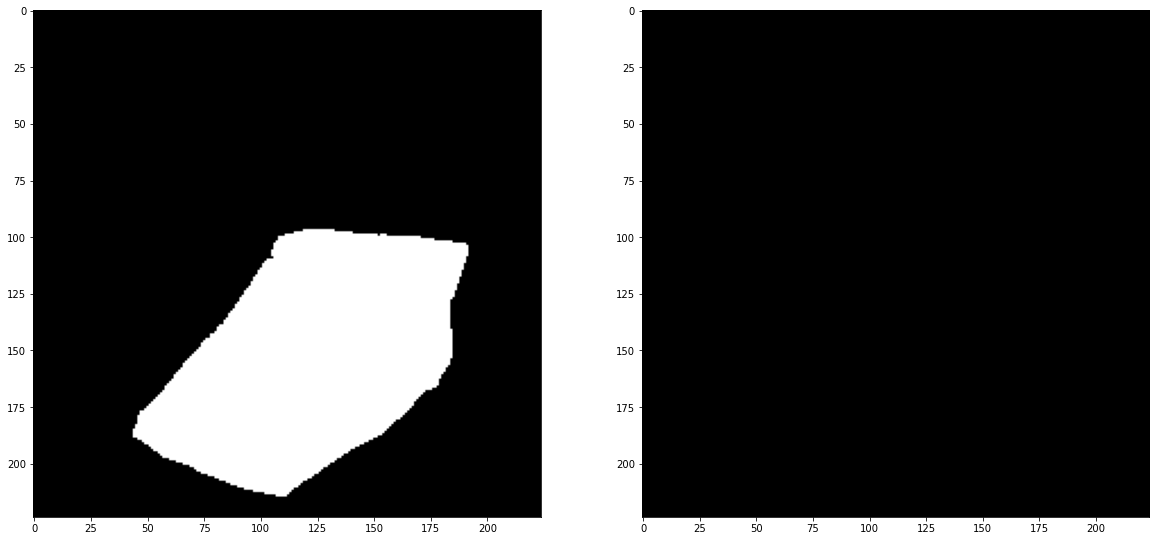

In [11]:
slc = 150
img_slice = img[0][slc].numpy()
mask_slice = mask[0][slc].numpy()

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(img_slice, vmin=0, vmax=1, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(mask_slice, vmin=0, vmax=1, cmap='gray')

## Prep for Training

In [12]:
# standard unet, 3 down-samples
f_size = 5
pad= int((f_size-1)/2)
channels = [32, 64, 128, 256]

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv3d(in_channels, out_channels, f_size, padding=(pad,pad,pad))
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, f_size, padding=(pad,pad,pad))
        self.bn2 = nn.BatchNorm3d(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x
    
class unet(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        # pooling
        self.pool = nn.MaxPool3d(2,2)
        
        # ENCODER

        # block 00 (down)
        self.conv00 = ConvBlock(1, channels[0])
        # block 10 (down)
        self.conv10 = ConvBlock(channels[0], channels[1])
        # block 20 (down)
        self.conv20 = ConvBlock(channels[1],channels[2])
        # block 30 (down)
        self.conv30 = ConvBlock(channels[2],channels[3])
        
        # DECODER
        
        # block 22 (up)
        self.upconv22 = nn.ConvTranspose3d(channels[3],channels[2],2,stride=2)
        self.conv22 = ConvBlock(2*channels[2],channels[2])
        # block 13 (up)
        self.upconv13 = nn.ConvTranspose3d(channels[2],channels[1],2,stride=2)
        self.conv13 = ConvBlock(2*channels[1],channels[1])
        # block 04 (up)
        self.upconv04 = nn.ConvTranspose3d(channels[1],channels[0],2,stride=2)
        self.conv04 = ConvBlock(2*channels[0],channels[0])
        
        # final layers
        self.final04 = nn.Conv3d(channels[0],1,1)
        
    def forward(self, x):
        
        # Encoder Path
        x00 = self.conv00(x)
        x10 = self.conv10(self.pool(x00))
        x20 = self.conv20(self.pool(x10))
        x = self.conv30(self.pool(x20))
        
        # Up-sampling second round
        x = self.upconv22(x)
        x = self.conv22(torch.cat((x20,x),dim=1))
        del x20
        
        # Up-sampling third round
        x = self.upconv13(x)
        x = self.conv13(torch.cat((x10,x),dim=1))
        del x10
        
        # Final up-sample
        x = self.upconv04(x)
        x = self.conv04(torch.cat((x00,x),dim=1))
        del x00
        
        # Outputs
        x = self.final04(x)
        
        return x
    
model = unet()

device = torch.device(5)
model = model.to(device)

In [13]:
alpha = 1.0
beta = .5

# different type of loss function based on correct area of segmentation
def dice(inputs, targets):
    inputs = torch.sigmoid(inputs)
    intersection = torch.sum(inputs * targets)
    dice = 1 -  ((2.*intersection + 1) / (torch.sum(inputs)+torch.sum(targets)+1))
    return dice

# best loss I think; this adds the dice weight to BCE loss
class ComboLoss(nn.Module):
    def __init__(self):
        super(ComboLoss, self).__init__()
    
    def forward(self, inputs, targets):
        BCloss = nn.BCEWithLogitsLoss()
        
        # only the tissue segmentation is weighted, because Gore doesn't really care about the mask
        return (alpha * BCloss(inputs,targets)) + (beta * dice(inputs, targets))

In [14]:
AMP = True

lossFun = ComboLoss()
#lossFun = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

if AMP == True:
    scaler = GradScaler()

## Train

In [15]:
#model_name = 'model_3downsamples'
model_name = 'model_3downsamples_f5'



# this is where I'm keeping my models
checkpoint = torch.load(f'/home/mruddy/mydata/AMAAZE/models/{model_name}.pth')
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
if AMP == True:
    scaler.load_state_dict(checkpoint['scaler'])

In [16]:
num_epochs = 10
batch_size = 1

train_losses = []  # collect the training losses
val_losses = []    # collect the validation losses

for ep in tqdm(range(num_epochs)):
    ep_start = time.time()
    
    model.train()
    train_loss = 0.0
    
    idx = 0
    
    # one pass through the training set
    for i, batch in enumerate(tqdm(dataloader_train, leave=False)):
        
        if (idx % batch_size == 0) or (idx == len(dataloader_train)):
            loss_oneBatch = 0.0
            optimizer.zero_grad()
        
        X_batch, Y_batch = batch[0], batch[1]
        
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        
        N_batch = X_batch.shape[0]
        if AMP == True:
            with autocast():
                outputs = model(X_batch)
                loss_oneBatch += lossFun(outputs, Y_batch)
        else:
            outputs = model(X_batch)
            loss_oneBatch += lossFun(outputs, Y_batch)
                                 
        # we load one image onto the GPU at a time, but backprop after batch_size many times
        if (idx % batch_size == 0) or (idx == len(dataloader_train)):
            if AMP == True:
                scaler.scale(loss_oneBatch).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss_oneBatch.backward()
                optimizer.step()
        
        train_loss += loss_oneBatch.item()*N_batch
        
        idx += 1
        
    # evaluate loss on validation data
    model.eval()
    val_loss = 0.0
    
    for X_batch, Y_batch in dataloader_val:
        
        N_batch = X_batch.shape[0]
        
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        
        with torch.no_grad():
            outputs = model(X_batch)
            loss_oneBatch = lossFun(outputs, Y_batch)
            val_loss += loss_oneBatch.item()*N_batch

    # collect losses, metrics, and timings
    train_losses.append(train_loss/N_train)
    val_losses.append(val_loss/N_val)
    ep_end = time.time() - ep_start
    
    # print data
    print('Ep:', ep, 
                ' Train_loss:', round(train_loss/N_train,7), 
                ' Val_loss:', round(val_loss/N_val,7),
                ' Time:', round(ep_end), 'seconds')

Ep: 0  Train_loss: 1.065928  Val_loss: 0.8771045  Time: 501 seconds


Ep: 1  Train_loss: 0.7489979  Val_loss: 0.6167618  Time: 505 seconds


Ep: 2  Train_loss: 0.616907  Val_loss: 0.5925235  Time: 510 seconds


Ep: 3  Train_loss: 0.5681544  Val_loss: 0.5573677  Time: 509 seconds


Ep: 4  Train_loss: 0.5517086  Val_loss: 0.510129  Time: 506 seconds


Ep: 5  Train_loss: 0.5471872  Val_loss: 0.5184824  Time: 504 seconds


Ep: 6  Train_loss: 0.5430938  Val_loss: 0.5765179  Time: 504 seconds


Ep: 7  Train_loss: 0.5294437  Val_loss: 0.5271392  Time: 503 seconds


Ep: 8  Train_loss: 0.5229297  Val_loss: 0.4818647  Time: 503 seconds


Ep: 9  Train_loss: 0.5253506  Val_loss: 0.5624384  Time: 503 seconds



In [17]:
model_name = 'model_3downsamples_f5'
checkpoint = {'state_dict': model.state_dict(),'optimizer' :optimizer.state_dict()}
if AMP == True:
    checkpoint['scaler'] = scaler.state_dict()
torch.save(checkpoint,f'/home/mruddy/mydata/AMAAZE/models/{model_name}.pth')

## Look at Predictions

In [16]:
X_batch, Y_batch = next(iter(dataloader_train))
N_batch = X_batch.shape[0]
X_batch = X_batch.to(device)

model.eval()
with torch.no_grad():
    Y_batch_pred = model(X_batch)

X = X_batch[0].cpu()
Y = Y_batch[0]
Y_pred = torch.sigmoid(Y_batch_pred[0].cpu())

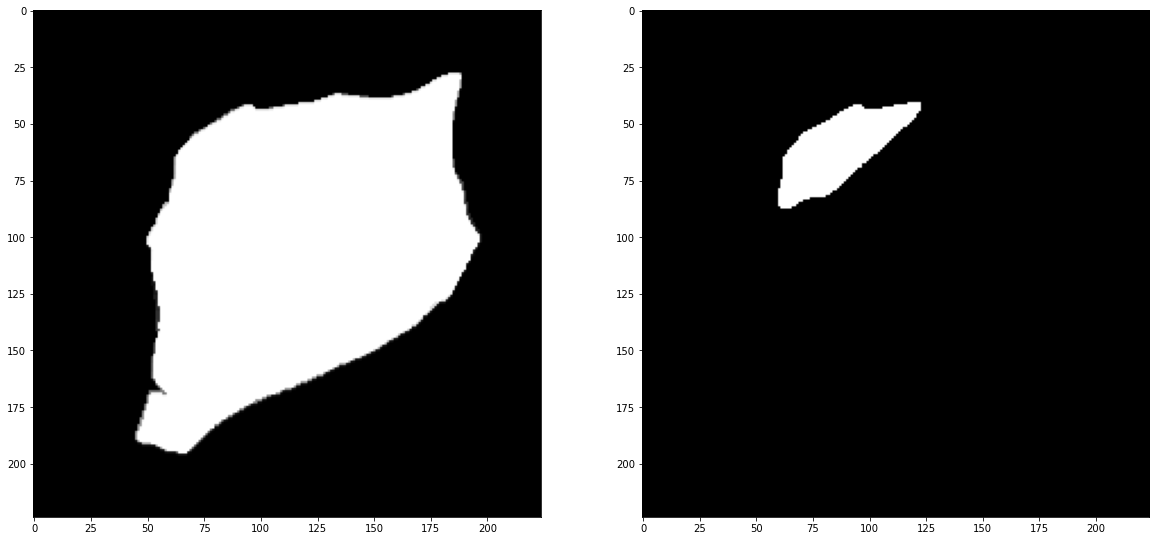

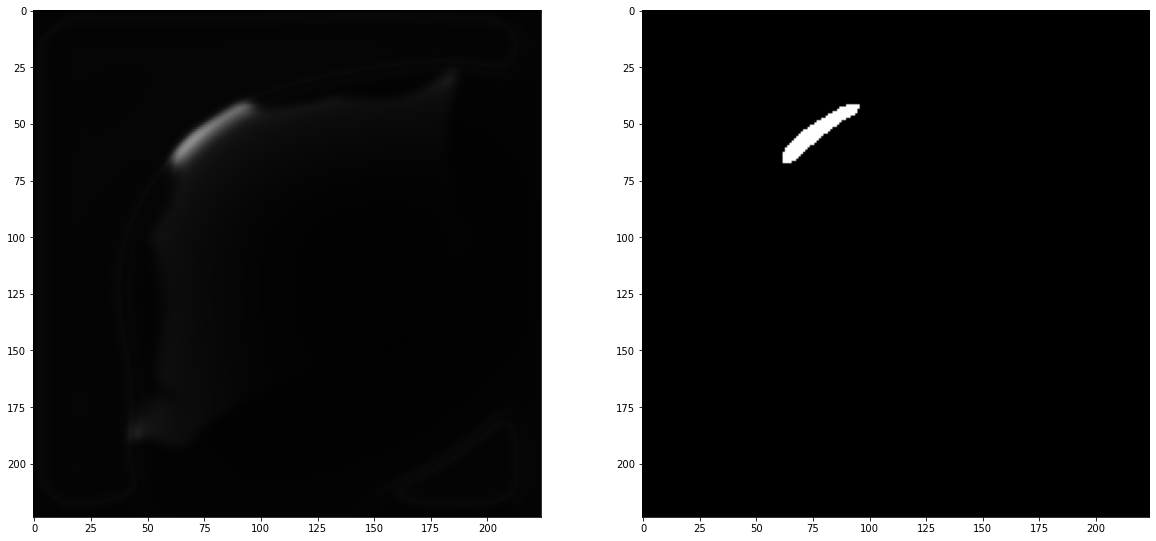

In [17]:
img = X[0].numpy()
mask = Y_pred[0].numpy()
truth = Y[0].numpy()

threshold = .25

mask_pred = np.zeros(mask.shape)
mask_pred[mask > threshold] = 1

dim = 0
slc = 100

if dim == 0:
    img = img[slc]
    mask = mask[slc]
    truth = truth[slc]
    mask_pred = mask_pred[slc]
if dim == 1:
    img = img[:,slc,:]
    mask = mask[:,slc,:]
    truth = truth[:,slc,:]
    mask_pred = mask_pred[slc]
if dim == 2:
    img = img[:,:,slc]
    mask = mask[:,:,slc]
    truth = truth[:,:,slc]
    mask_pred = mask_pred[slc]


plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(img, vmin=0, vmax=1, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(truth, vmin=0, vmax=1, cmap='gray')

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(mask, vmin=0, vmax=1, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(mask_pred, vmin=0, vmax=1, cmap='gray')

In [18]:
def image_to_mesh(input_image, radius=3):
    points = []
    for slc in range(mask_pred.shape[0]):
        image = input_image[slc]
        blank = np.zeros(image.shape)

        ret,thresh = cv2.threshold(255*np.array(image,dtype=np.uint8),127,255,0)
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        img = cv2.drawContours(blank, contours, -1, 255, thickness=1)

        for contour in contours:
            for point in contour:
                point = point[0]
                points.append([point[0],point[1],slc])
    points = np.array(points)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.estimate_normals()
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
           pcd,
           o3d.utility.DoubleVector([radius, radius * 2]))
    mesh = trimesh.Trimesh(np.asarray(mesh.vertices), np.asarray(mesh.triangles),
                          vertex_normals=np.asarray(mesh.vertex_normals))
    return points

In [19]:
mask = Y_pred[0].numpy()
threshold = .25
mask_pred = np.zeros(mask.shape)
mask_pred[mask > threshold] = 1

points = image_to_mesh(mask_pred, radius=3)

In [21]:
%matplotlib notebook

<IPython.core.display.Javascript object>


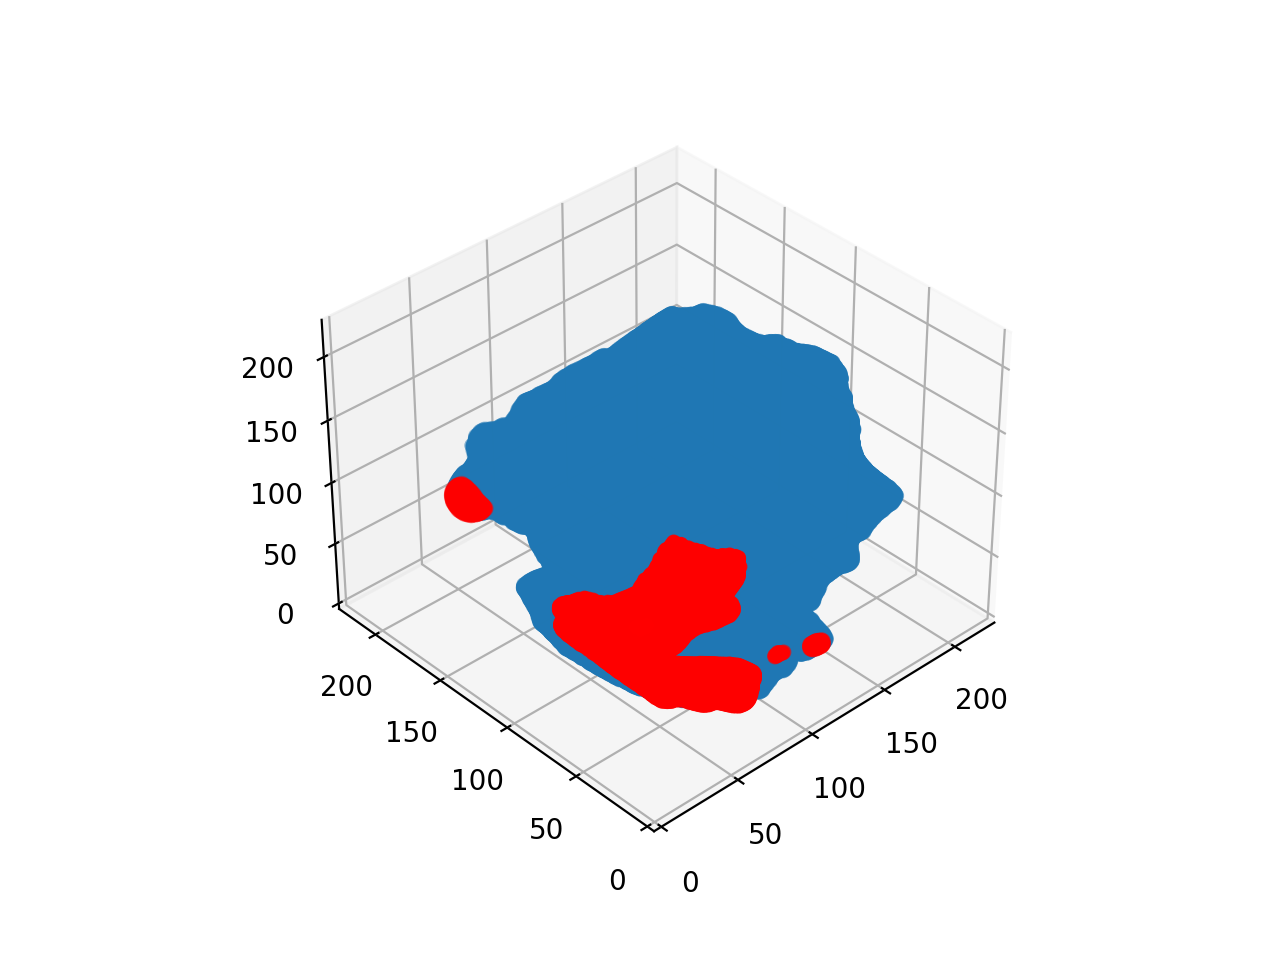

In [28]:
from mpl_toolkits import mplot3d

mask = Y_pred[0].numpy()
threshold = .25
mask_pred = np.zeros(mask.shape)
mask_pred[mask > threshold] = 1
points = image_to_mesh(mask_pred, radius=1)
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.set(xlim=(0, 224), ylim=(0, 224),zlim=(0, 224))
ax.scatter3D(points[:,0], points[:,1], points[:,2], color='red')

img = X[0].numpy()
points = image_to_mesh(img, radius=1)
ax.scatter3D(points[:,0], points[:,1], points[:,2])
plt.show()

<IPython.core.display.Javascript object>


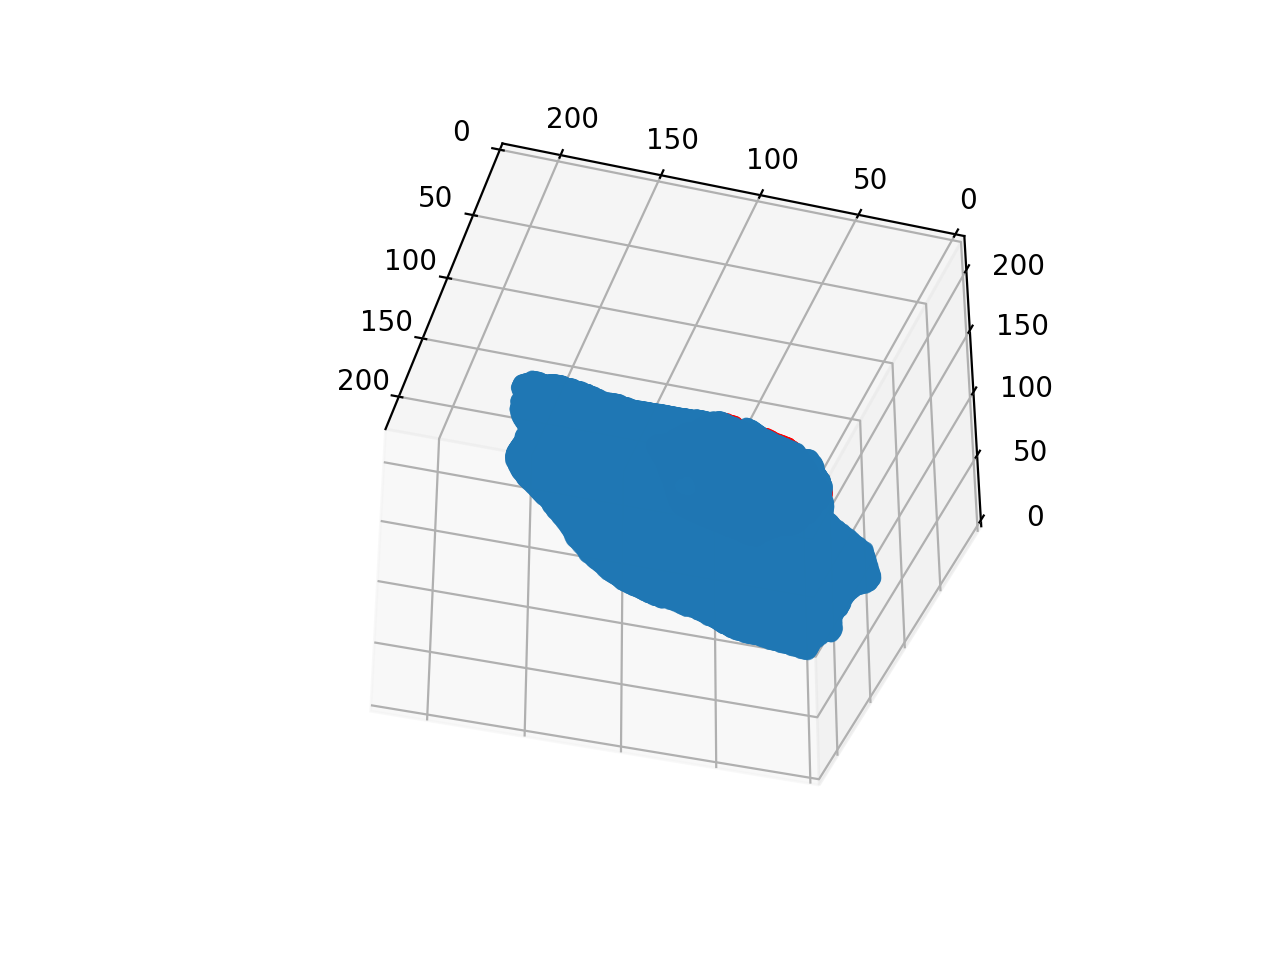

In [30]:
from mpl_toolkits import mplot3d

truth = Y[0].numpy()
points = image_to_mesh(truth, radius=1)
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.set(xlim=(0, 224), ylim=(0, 224),zlim=(0, 224))
ax.scatter3D(points[:,0], points[:,1], points[:,2], color='red')

img = X[0].numpy()
points = image_to_mesh(img, radius=1)
ax.scatter3D(points[:,0], points[:,1], points[:,2])
plt.show()